In [26]:
import pandas as pd
import numpy as np
from pandas_datareader import data
import matplotlib.pyplot as plt
import quandl
import datetime
%matplotlib inline

In [46]:
# Download data into DataFrame and create moving averages columns
#df = data.DataReader('AAPL', 'yahoo', start='1/1/2000')

# Must always use my API key to retrieve data from Quandl (API below is mine)
quandl.ApiConfig.api_key = 'Mi3wqM8sAdy5UfpmFKvN'

# Get Quandl data series (does not retrieve the 'ticker' column) and Column names will be Upper Case
df = quandl.get('WIKI/AAPL', start_date='2000-01-01', end_date='2017-12-31', paginate=True)


# To retrieve a table, use this syntax. Column names will be lower case
#df = quandl.get_table('WIKI/PRICES', ticker='AAPL', date={'gte': '2016-01-01', 'lte': '2017-12-31'}, paginate=True)

# If you wanted to retrieve multiple tickers, you must use a table and the following syntax
#df = quandl.get_table('WIKI/PRICES', qopts = { 'columns': ['ticker', 'date', 'open', 'high', 'low', 'close'] }, 
 #                     ticker = ['AAPL', 'MSFT'], date={ 'gte': '2016-01-01', 'lte': '2017-12-31' }, paginate=True)

# TABLE ONLY: After retrieving data, change the date to a datetime series and set it as the index
#df['Date'] = pd.to_datetime(df['Date'])
#df.set_index('Date', inplace=True)


In [47]:
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2000-01-03,104.87,112.50,101.69,111.94,4783900.0,0.0,1.0,3.369314,3.614454,3.267146,3.596463,133949200.0
2000-01-04,108.25,110.62,101.19,102.50,4574800.0,0.0,1.0,3.477908,3.554053,3.251081,3.293170,128094400.0
2000-01-05,103.75,110.56,103.00,104.00,6949300.0,0.0,1.0,3.333330,3.552125,3.309234,3.341362,194580400.0
2000-01-06,106.12,107.00,95.00,95.00,6856900.0,0.0,1.0,3.409475,3.437748,3.052206,3.052206,191993200.0
2000-01-07,96.50,101.00,95.50,99.50,4113700.0,0.0,1.0,3.100399,3.244977,3.068270,3.196784,115183600.0


In [48]:
# Create the "L14" column (14 day low) in the DataFrame
df['L14'] = df['Low'].rolling(window=14).min()

# Create the "H14" column (14 day high) in the DataFrame
df['H14'] = df['High'].rolling(window=14).max()

# Create the "%K" column in the DataFrame
df['%K'] = 100*((df['Close'] - df['L14']) / (df['H14'] - df['L14']))

# Create the "%D" column in the DataFrame
df['%D'] = df['%K'].rolling(window=3).mean()

Text(0.5,1,'Oscillator')

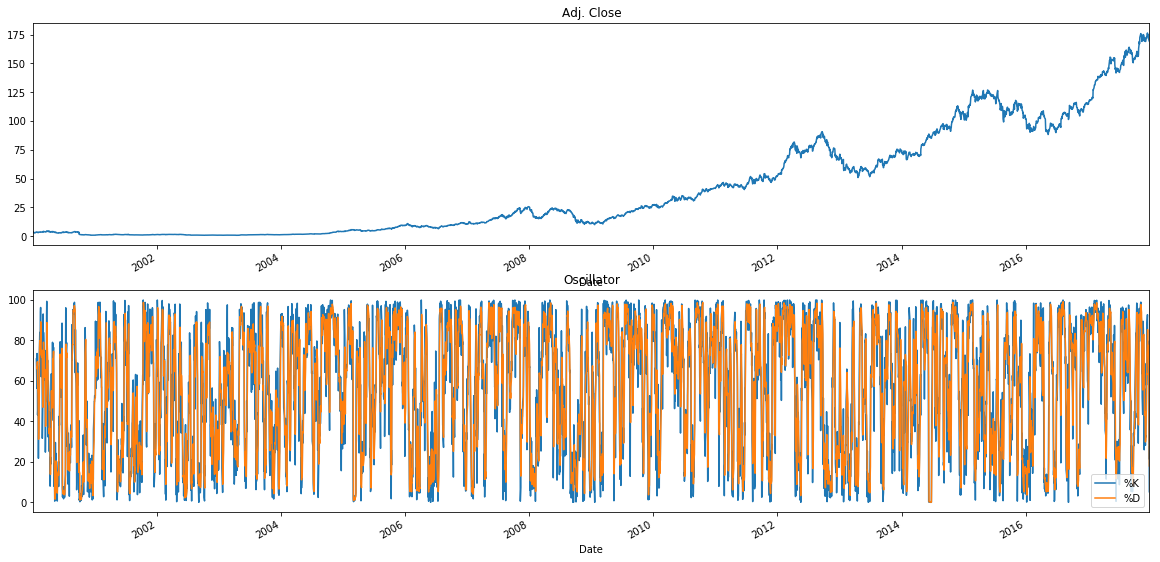

In [50]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))

df['Adj. Close'].plot(ax=axes[0]); axes[0].set_title('Adj. Close')
df[['%K', '%D']].plot(ax=axes[1]); axes[1].set_title('Oscillator')

In [56]:
# A sell is initiated when the %K line crosses down through the %D line and the value of the oscillator is above 80
df['Sell Entry'] = ((df['%K'] < df['%D']) & (df['%K'].shift(1) > df['%D'].shift(1))) & (df['%D'] > 80)

# Create a column in the DataFrame showing "TRUE" if sell exit signal is given and "FALSE" otherwise.
# A sell exit signal is given when the %K line crosses back up through the %D line
df['Sell Exit'] = ((df['%K'] > df['%D']) & (df['%K'].shift(1) < df['%D'].shift(1))) #create a placeholder column

# A buy entry signal is given when the %K line passes up through the %D line and the %K line is under 20
df['Buy Entry'] = ((df['%K'] > df['%D']) & (df['%K'].shift(1) < df['%D'].shift(1))) & (df['%K'] < 20)

# Create a column in the DataFrame showing "TRUE" if buy exit signal is given and "FALSE" otherwise.
# A buy exit signal is given when the %K line crosses back down through the %D line
df['Buy Exit'] = ((df['%K'] < df['%D']) & (df['%K'].shift(1) > df['%D'].shift(1)))

# Create a placeholder column to populate with long positions (1 for long and 0 for flat) using boolean values created above
df['Long'] = np.nan
df.loc[df['Buy Entry'], 'Long'] = 1
df.loc[df['Buy Exit'], 'Long'] = 0

df['Short'] = np.nan
df.loc[df['Sell Entry'], 'Short'] = -1
df.loc[df['Sell Exit'], 'Short'] = 0


# Set initial position on day 1 to flat
df.iloc[0,df.columns.get_loc('Long')] = 0
df.iloc[0,df.columns.get_loc('Short')] = 0

# Forward fill the position column to represent the holding of positions through time
df['Long'] = df['Long'].fillna(method='pad')

# Add Long and Short positions together to get final strategy position (1 for long, -1 for short, and 0 for flat)
df['Position'] = df['Long'] + df['Short']

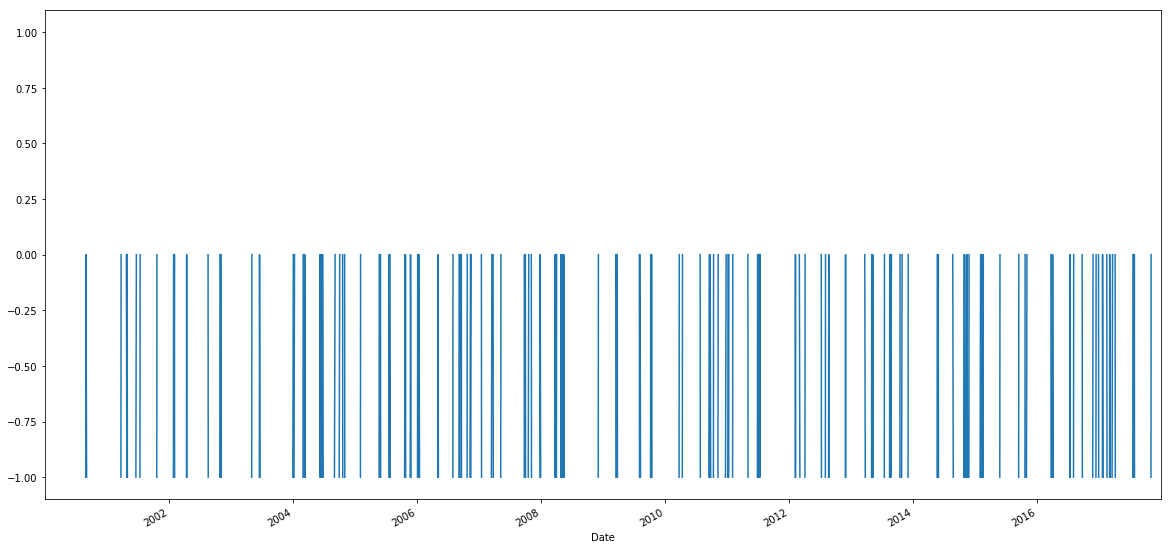

In [58]:
df['Position'].plot(figsize=(20,10))
# This isn't right. There are no long positions. Take another look at the code and fix it.

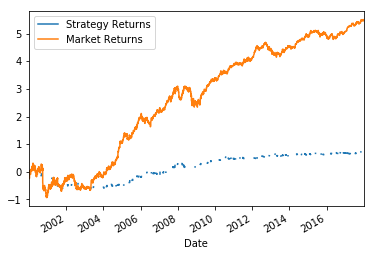

In [59]:
# Set up a column holding the daily Apple returns
df['Market Returns'] = df['Adj. Close'].pct_change()

# Create a column for Strategy Returns by multiplying the daily Apple price returns by the position that was held...
# ...at close of business the previous day.
df['Strategy Returns'] = df['Market Returns'] * df['Position'].shift(1)

# Finally, plot the strategy returns versus Apple returns
df[['Strategy Returns', 'Market Returns']].cumsum().plot()